<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка библиотек

Импортируем все необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import os
import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     StratifiedKFold)

from pymystem3 import Mystem
from sklearn import metrics
import warnings

m = Mystem()
warnings.filterwarnings('ignore')

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
pd.set_option('display.max_colwidth', 100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Загрузка данных

Загрузим данные, указав разные пути, а также проверим тип данных в датасете:

In [3]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


На данном этапе с данными все в порядке! Проверим наличие пропусков:

In [5]:
df.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Пропусков нет! Можем дальше предобработать данные и удалить неинформативный столбец:

In [6]:
df = df.drop(columns=["Unnamed: 0"])

После этого проведем проверку на дубликаты:

In [7]:
df.duplicated().sum()

0

В датафрейме остались только репрезентативные данные, нет пропусков и дубликатов: он готов к дальнейшим этапам работы!

### Анализ данных

Посмотрим, как распределен целевой признак:

In [8]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Налицо дисбаланс ;( Визуализируем эту невеселую ситуацию:

Отношение количества токсичных комментариев к обычным:  0.11


<Axes: >

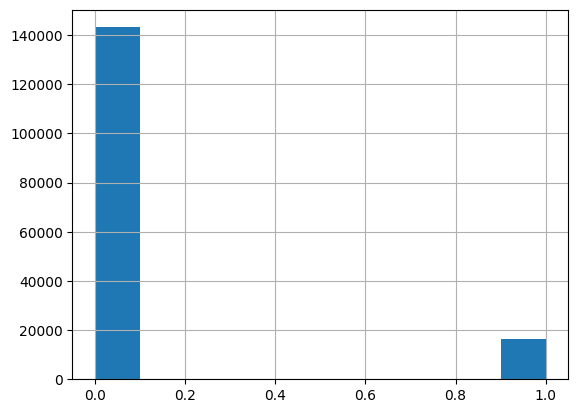

In [9]:
length = len(df.loc[df['toxic'] == 1]) / len(df.loc[df['toxic']==0])
print('Отношение количества токсичных комментариев к обычным: ', 
      round(length,2))
df['toxic'].hist()

Действительно целевые значения распределены неравномерно. Обязательно учтем это на следующих этапах!

### Подготовка данных

Создадим копию исходного датафрейма и будем работать с ней:

In [10]:
work_df = df.copy()
work_df.head()

,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Напишем функцию для лемматизации текста и применим ее:

In [11]:
def process_text(text):
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
   
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    text = ' '.join(tokens)
    return text

In [12]:
work_df['lemma_text'] = df['text'].apply(process_text)

Проверим, все ли получилось:

In [13]:
work_df.head()

,text,toxic,lemma_text
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new yor...
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,aww match background colour seemingly stuck thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,hey man really try edit war guy constantly remove relevant information talk edits instead talk p...
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0,make real suggestion improvement wonder section statistic later subsection type accident think r...
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page


In [14]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   lemma_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


## Обучение

Разделим данные таким образом, чтобы потом использовать их для обучения моделей:

In [23]:
col = 'toxic'

features = pd.DataFrame(data=work_df.drop(col, axis=1))
target = pd.DataFrame(data=work_df[col])

Применим стратификацию при разделении на выборки, чтобы учесть дисбаланс классов:

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.15, random_state=42, stratify=target)

In [25]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135398 entries, 107160 to 85790
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        135398 non-null  object
 1   lemma_text  135398 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


Укажем стоп-слова и проведем векторизацию данных:

In [26]:
stopwords_list = set(stopwords.words('english'))

vectorizer = TfidfVectorizer(stop_words=list(stopwords_list), max_features = 2048)
tf_idf_tr = vectorizer.fit_transform(features_train['lemma_text'] )

tf_idf_test = vectorizer.transform(features_test['lemma_text'])

print("Размер матрицы:", tf_idf_tr.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (135398, 2048)
Размер матрицы: (23894, 2048)


Воспользуемся перекрестной проверкой: каждый набор данных будет содержать примерно такой же процент выборок каждого целевого класса, что и полный набор:

In [27]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(features_train, target_train)

5

Шалость удалась! Переходим к обучению моделей и выбору лучшей из них:

In [30]:
data_preprocessor = ColumnTransformer([
    ("text", TfidfVectorizer(), 'lemma_text')])

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7)  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5)   
    },

    {
        'models': [LogisticRegression(
            random_state=42, 
            solver= 'liblinear'
        )],
        'models__C': range(1, 10),
        'models__penalty': ['l1', 'l2']  
    }
  
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(features_train, target_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 4))

y_test_pred = randomized_search.predict(features_test)
f1_test = f1_score(target_test, y_test_pred)
print(f'Метрика F1 на тестовой выборке: {round(f1_test, 2)}') 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text', TfidfVectorizer(),
                                                  'lemma_text')])),
                ('models',
                 LogisticRegression(C=7, random_state=42, solver='liblinear'))])
Метрика лучшей модели на тренировочной выборке: 0.7716
Метрика F1 на тестовой выборке: 0.79


## Выводы

    Заказчик - магазин "Викишоп" - предоставил таблицу с текстами комментариев и их классификацией: токсичные они или нет. 

    Данные были предобработаны, проанализированы и подготовлены для обучения.

    Были обучены три модели машинного обучения LogisticRegression, DecisionTreeClassifier и KNeighborsClassifier. Был проведен подбор гиперпараметров и выбрана лучшая модель. 

    Лучшей из моделей оказалась логистическая регрессия с параметрами, которые будут указаны ниже. 

    На тестовой выборке метрика оказалась выше, чем на тренировочной, то есть модель не переобучена и действительно хорошо классифицирует: значение на каждой из выборок больше требуемого заказчиком.


In [31]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text', TfidfVectorizer(),
                                                  'lemma_text')])),
                ('models',
                 LogisticRegression(C=7, random_state=42, solver='liblinear'))])
